<a href="https://colab.research.google.com/github/DomjanKatarina/House-Pricing-Kaggle-Competition/blob/main/predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The challange

Predict the final price of each home ([Kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)).

I've performed an Exploratory Data Analysis of the dataset in another notebook called `EDA.ipynb`.

I'm going to use three different models for prediction:
- Neural Network
- XGBoost
- Random Forest

These three models are going to be compered and then we will predict the test set with the best model.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import warnings
import itertools
import time
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [19]:
# import the train set
df_train = pd.read_csv('https://raw.githubusercontent.com/DomjanKatarina/House-Pricing-Kaggle-Competition/main/Dataset/train.csv', index_col=0)
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
# import the test set
df_test = pd.read_csv('https://raw.githubusercontent.com/DomjanKatarina/House-Pricing-Kaggle-Competition/main/Dataset/test.csv', index_col=0)
df_test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [21]:
# changing the type of variables that were taken as numerical and they should be taken as categorical 
should_be_cat = ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
for var in should_be_cat + list(df_train.select_dtypes(include=['object', 'category']).columns) :
    df_train[var] = df_train[var].astype('category', copy=False)   # Other possible types: 'int64', 'float64', 'object'
    df_test[var] = df_test[var].astype('category', copy=False)

In [22]:
# drop the necesarry columns (previous EDA)
df_train = df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'LotFrontage'])
df_test = df_test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'LotFrontage'])

In [23]:
# adding categories and Boolean variables for Garage, Basement and Pool (EDA)
garage_var = ['GarageQual', 'GarageType', 'GarageFinish']
for var in garage_var:
    df_train[var] = df_train[var].cat.add_categories(['Missing'])
    df_test[var] = df_test[var].cat.add_categories(['Missing'])
    df_train[var] = df_train[var].fillna('Missing')
    df_test[var] = df_test[var].fillna('Missing')

df_train['Garage'] = [0 if x==0 else 1 for x in df_train['GarageArea']]
df_test['Garage'] = [0 if x==0 else 1 for x in df_test['GarageArea']]
df_train['Garage'] = df_train['Garage'].astype('bool',copy=False)
df_test['Garage'] = df_test['Garage'].astype('bool',copy=False)

bsmt_var = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for var in bsmt_var:
    df_train[var] = df_train[var].cat.add_categories(['MissingBsmt'])
    df_test[var] = df_test[var].cat.add_categories(['MissingBsmt'])
    df_train[var] = df_train[var].fillna('MissingBsmt')
    df_test[var] = df_test[var].fillna('MissingBsmt')

df_train['Bsmt'] = [0 if x==0 else 1 for x in df_train['TotalBsmtSF']]
df_test['Bsmt'] = [0 if x==0 else 1 for x in df_test['TotalBsmtSF']]
df_train['Bsmt'] = df_train['Bsmt'].astype('bool',copy=False)
df_test['Bsmt'] = df_test['Bsmt'].astype('bool',copy=False)

df_train['Pool'] = [0 if x==0 else 1 for x in df_train['PoolArea']]
df_test['Pool'] = [0 if x==0 else 1 for x in df_test['PoolArea']]
df_train['Pool'] = df_train['Pool'].astype('bool',copy=False)
df_test['Pool'] = df_test['Pool'].astype('bool',copy=False)

In [24]:
# updating lists of categorical and numerical variables
cat_var = list(df_train.select_dtypes(include=['object', 'category']).columns) 
cat_var = [var for var in cat_var if (df_train[var].nunique() < 10) or (var in ['Neighborhood', 'MoSold'])]

num_var = list(df_train.select_dtypes(include=['number']).columns)
num_var.remove('SalePrice')

In [25]:
# removing categorical variables that have more categories in test set than in train set
cat_var_1 = cat_var
for var in cat_var_1:
  in_train = set(df_train[var].cat.categories)
  in_test = set(df_test[var].cat.categories)

  missing_categories = list(in_test-in_train)
  if len(missing_categories) != 0:
    df_train.drop(columns=[var])
    df_test.drop(columns=[var])
    cat_var.remove(var)

In [26]:
# dividing the dataframe into independent variables and dependent variable
X = df_train.drop(columns=['SalePrice']).reset_index(drop=True)
y = df_train.SalePrice

# Deep Neural Network

Possible twigs: 
- number of units
- activation function: `relu`, `elu`, `selu`, `swish`
- loss function: MAE, MSE, Huber
- optimizer
- size of minibatches
- learning rate

---

**Tensors and weights** 

Keras represents the weights of a neural network with tensors. Tensors are basically TensorFlow's version of a Numpy array with a few differences that make them better suited to deep learning. One of the most important is that tensors are compatible with GPU and TPU accelerators. TPUs, in fact, are designed specifically for tensor computations.

Before the model is trained, the weights are set to random numbers and the bias to 0. A neural network learns by finding better values for its weights.

The key idea here is *modularity*, building up a complex network from simpler functional units.

---

**[Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)** 

Neural networks typically organize their neurons into **layers**. When we collect together linear units having a common set of inputs we get a **dense** layer. You could think of each layer in a neural network as performing some kind of relatively simple transformation. Through a deep stack of layers, a neural network can transform its inputs in more and more complex ways. In a well-trained neural network, each layer is a transformation getting us a little bit closer to a solution.

The layers before the output layer are sometimes called **hidden** since we never see their outputs directly.

**Dropout layer** can help correct overfitting. We randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust. You could also think about dropout as creating a kind of ensemble of networks. The predictions will no longer be made by one big network, but instead by a committee of smaller networks. When adding dropout, you may need to increase the number of units in your Dense layers.

**Batch normalization** can help correct training that is slow or unstable. With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. It's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training. You can put it between layers or after the layer (between units and activation or after activation). And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's StandardScaler.

---

**Activation function** 

Two dense layers with nothing in between are no better than a single dense layer by itself. Dense layers by themselves can never move us out of the world of lines and planes. We need something nonlinear: activation functions.

An activation function is simply some function we apply to each of a layer's outputs (its activations). The most common is the *rectifier* function  `max(0,x)`. When we attach the rectifier to a linear unit, we get a rectified linear unit or **ReLU**. Applying a ReLU activation to a linear unit means the output becomes `max(0, w * x + b)`.

Notice that the final (output) layer is a linear unit (meaning, no activation function). That makes this network appropriate to a regression task. Other tasks (like classification) might require an activation function on the output.

---

**Loss function**

The loss function measures the disparity between the the target's true value and the value the model predicts. In other words, we tell the NN what problem to solve.

A common loss functions for regression problems are:
- MAE
- MSE
- Huber loss (less sensitive to outliers).

---

**Optimizer**

The optimizer is an algorithm that adjusts the weights to minimize the loss. In other words, we tell the NN how to solve the problem.

Virtually all of the optimization algorithms used in deep learning belong to a family called **stochastic gradient descent**. They are iterative algorithms that train a network in steps. One step of training goes like this:

1. Sample some training data and run it through the network to make predictions.
2. Measure the loss between the predictions and the true values.
3. Finally, adjust the weights in a direction that makes the loss smaller.

Then just do this over and over until the loss is as small as you like (or until it won't decrease any further.)

---

**Batch and epoch**

**Minibatch (batch)**: Each iteration's sample of training data. 

**Epoch**: a complete round of the training data. The number of epochs you train for is how many times the network will see each training example.

---

**Learning rate**

The size of these shifts towards the best fit is determined by the learning rate. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

The learning rate and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds.

**Adam** is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.

---

**Overfitting and underfitting**

*Underfitting* the training set is when the loss is not as low as it could be because the model hasn't learned enough signal. If it appears that your network is underfitting the data, you should try increasing its capacity. You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). We can use early stopping as well, to give model enough time to learn all the signal it can. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.

*Overfitting* the training set is when the loss is not as low as it could be because the model learned too much noise. We can prevent overfitting with **early stopping**. 



---

**Some hints:**

- Neural networks tend to perform best when their inputs are on a common scale.
- Deciding the architecture of your model should be part of a process. Start simple and use the validation loss as your guide.


In [ ]:
"""
# 'MasVnrArea' is causing nans of the network
# taking just a few of the variables to train the neural network (EDA)
num_var1 = ['YearBuilt', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
cat_var1 = ['GarageCars', 'Garage', 'Pool', 'Bsmt', 'OverallQual', 'YrSold', 'MoSold', 'Heating', 'HouseStyle']

X = pd.concat([X[num_var1], X[cat_var1]], axis=1)
"""

In [28]:
# taking just a few of the variables to train the neural network (EDA)
X_nn = X[['GarageCars', 'TotalBsmtSF', 'GrLivArea', 'Garage', 'Pool', 'Bsmt', 'Neighborhood', 'OverallQual', '1stFlrSF', 'YearBuilt']]

X_nn['TotalBsmtSF'] = np.log1p(X_nn['TotalBsmtSF'])
X_nn['GrLivArea'] = np.log1p(X_nn['GrLivArea'])
X_nn['1stFlrSF'] = np.log1p(X_nn['1stFlrSF'])

In [29]:
# applying One Hot Encoder to categorical variables
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include='category')),
)

X_nn = preprocessor.fit_transform(X_nn)
y_nn = np.log1p(y)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X_nn, y_nn, train_size=0.8, test_size=0.2, random_state=0)

In [31]:
# applying Standard Scaler to numerical variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_valid = scaler.transform(X_valid)

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

In [ ]:
"""
# Possible activation function and its graphs - a bit of theory
activations = ['relu', 'elu', 'selu', 'swish']

for activation in activations:
  activation_layer = layers.Activation(activation)

  x = tf.linspace(-3.0, 3.0, 100)
  y = activation_layer(x) # once created, a layer is callable just like a function

  plt.figure(dpi=100)
  plt.plot(x, y)
  plt.xlim(-3, 3)
  plt.xlabel("Input")
  plt.ylabel("Output")
  plt.title(activation)
  plt.show()
"""

In [ ]:
"""
# Create a network with 1 linear unit
model = keras.Sequential([
    # hidden layers
    layers.Dense(units=512, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(units=512, activation='relu'),
    # the linear output layer
    layers.Dense(units=1)
])

#w, b = model.weights
#print("Weights\n{}\n\nBias\n{}".format(w, b))
"""

In [35]:
model = keras.Sequential([
    layers.Dense(units=125, input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Activation('selu'),
    layers.Dense(units=125),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(units=125),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.Dense(units=125),
    layers.Activation('selu'),
    layers.Dense(units=1)
])

# We will not add the dropout layer as it seems our network is underfitting
# layers.Dropout(rate=0.3), # apply 30% dropout to the next layer

In [36]:
# Adding loss function and optimizer
model.compile(
    optimizer="adam",
    loss="mae",
)

In [37]:
# adding early stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [38]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=400,
    epochs=500,
    callbacks = early_stopping,
    verbose = 0  # turn of the training log
)

Minimum validation loss: 0.2047833949327469


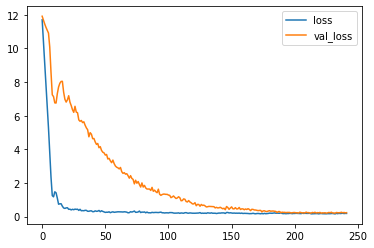

In [39]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
#history_df['loss'].plot()
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# XGBoost

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model (naive predictions). Then, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
- Add the new model to the ensemble and repeat.

---
`n_estimators` specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble. Typical values range from 100-1000, though this depends a lot on the `learning_rate`.

---
`early_stopping_rounds` offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating. Setting `early_stopping_rounds=5` is a reasonable choice.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter.

---
`learning_rate`

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for `n_estimators` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets `learning_rate=0.1`.

In [40]:
# prepare the X and y set
X_xgb = df_train.drop(columns=['SalePrice'])

skewed_feats = X_xgb[num_var].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

X_xgb[skewed_feats] = np.log1p(X_xgb[skewed_feats])

y = df_train.SalePrice
y = np.log1p(y)  # There isn't any data leakage involved as log1p does not learn any parameters such as mean or std from the data

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


In [41]:
# divide in train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_xgb, y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)

(1168, 74)
(292, 74)


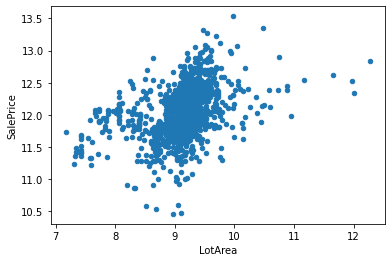

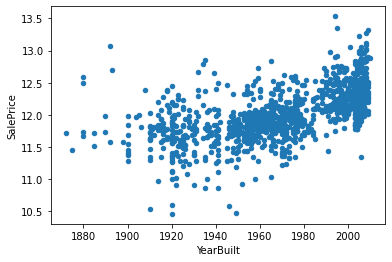

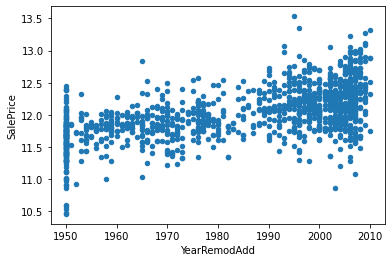

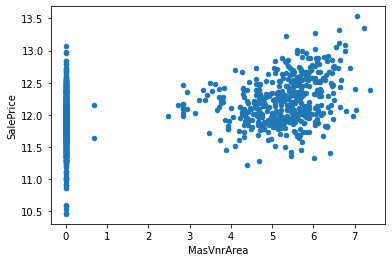

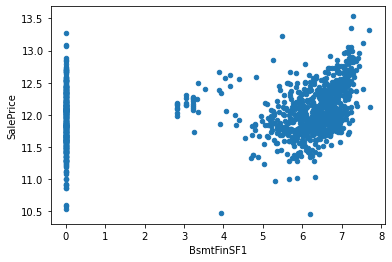

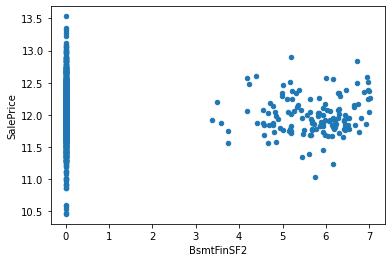

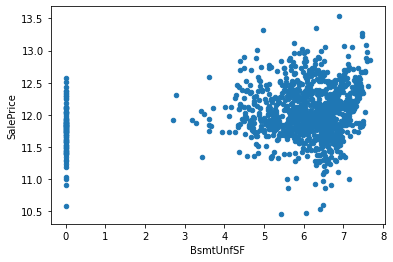

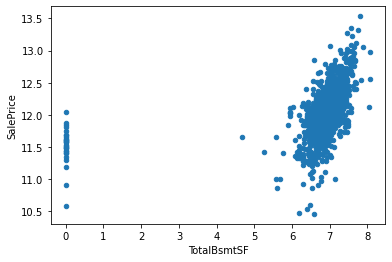

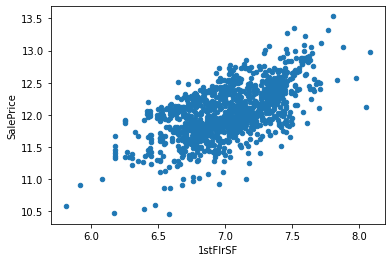

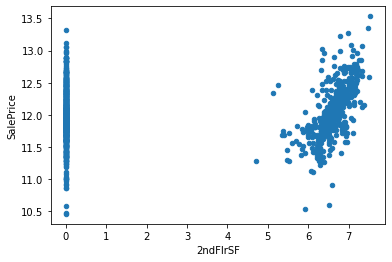

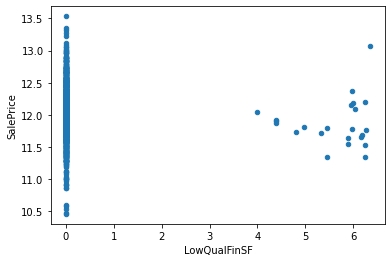

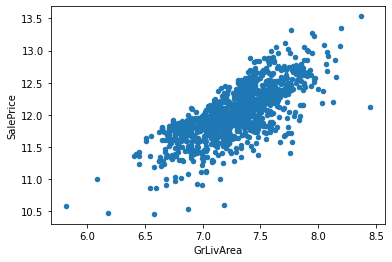

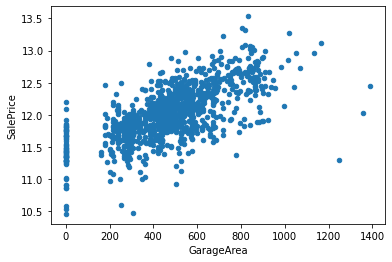

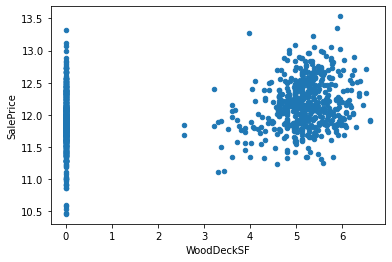

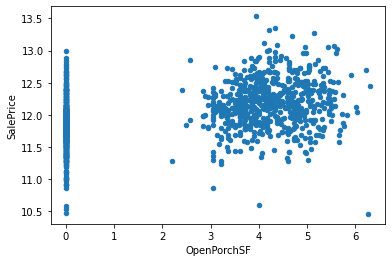

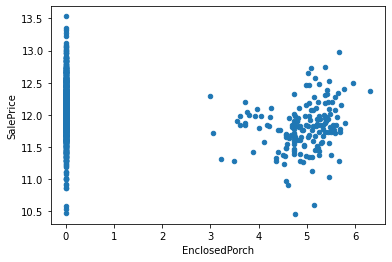

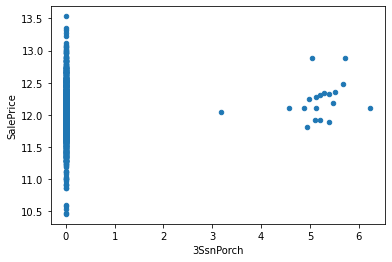

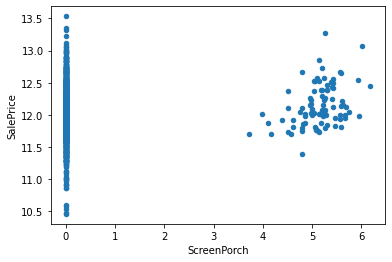

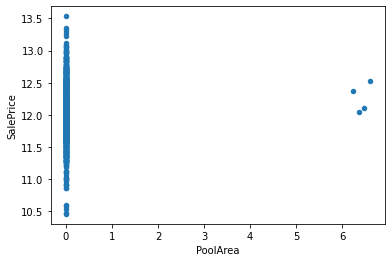

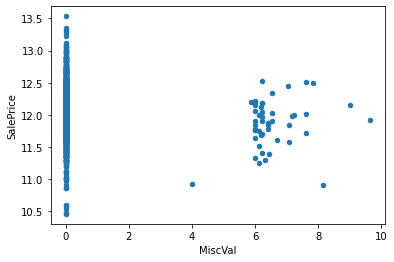

In [42]:
# let's observe the relationship between SalePrice and numerical variables in X (find outliers, correlation, ...)
for var in num_var:
  data = pd.concat([y_train, X_train[var]], axis=1)
  data.plot.scatter(x=var, y='SalePrice');

In [43]:
# delete outliers of 'GrLivArea'
to_drop = list(X_train.index[X_train['GrLivArea']>8.3])
X_train = X_train.drop(labels=to_drop)
y_train = y_train.drop(labels=to_drop)

# delete outliers of 'GarageArea'
to_drop = list(X_train.index[X_train['GarageArea']>1200])
X_train = X_train.drop(labels=to_drop)
y_train = y_train.drop(labels=to_drop)

In [44]:
# filling in the missing values of numerical columns
num_X_train = X_train[num_var]
num_X_valid = X_valid[num_var]

my_imputer = SimpleImputer(strategy='mean')

num_X_train = pd.DataFrame(my_imputer.fit_transform(num_X_train)).reset_index(drop=True)
num_X_valid = pd.DataFrame(my_imputer.transform(num_X_valid)).reset_index(drop=True)

num_X_train.columns = X_train[num_var].columns
num_X_valid.columns = X_valid[num_var].columns

In [45]:
# apply one hot encoder for categorical variables
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cat_var]))
OH_cols_train.columns = OH_encoder.get_feature_names()
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[cat_var]))
OH_cols_valid.columns = OH_encoder.get_feature_names()

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

OH_cols_train.reset_index(drop=True, inplace=True)
OH_cols_valid.reset_index(drop=True, inplace=True)

In [46]:
# determine X train and validation sets with the transformed columns
X_train = pd.concat([num_X_train, OH_cols_train, X_train[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid, X_valid[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)

In [47]:
# find the best parameters for the model and it's mae
def best_model(param_comb, data):
  X_train, y_train, X_valid, y_valid = data[0], data[1], data[2], data[3]
  mae_final = None
  best_comb = None

  for comb in param_comb:
    model = XGBRegressor(n_estimators=comb[0], learning_rate=comb[1])
    model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

    # get predictions
    predictions = model.predict(X_valid)
    #mae = mean_absolute_error(np.expm1(predictions), np.expm1(y_valid))
    mae = mean_absolute_error(predictions, y_valid)

    if (mae_final == None) or (mae < mae_final):
      mae_final = mae
      best_comb = comb

    #print("Parameters: " + str(comb))
    #print("Mean Absolute Error: " + str(mae) + "\n")

  return best_comb, mae_final 

In [48]:
xgb_n_estimators = [100, 250, 500, 1000]
xgb_learning_rate = [0.01, 0.05, 0.1, 0.5, 1]

param_comb = list(itertools.product(xgb_n_estimators, xgb_learning_rate))

data = [X_train, y_train, X_valid, y_valid]

best_comb, mae = best_model(param_comb, data)
print("Best parameters: ", best_comb)
print("Best MAE: ", mae)

[10:01:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
"""
class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self,  X_train, y_train, X_valid, y_valid, 
                 early_stopping_rounds=5, eval_metric='mae', **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.eval_metric=eval_metric=eval_metric      
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.estimator.fit(X_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, 
                           eval_set=[(X_valid, y_valid)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)
"""

In [ ]:
"""
numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_var),
        ('cat', categorical_transformer, cat_var)
    ])
"""

In [ ]:
"""
pipeline = Pipeline([('preprocessor', preprocessor),
    ('xgb', XGBoostRegressorWithEarlyStop(X_train, y_train, X_valid, y_valid))
])

param_grid = {
    "xgb__n_estimators": [100, 250, 500, 100],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
}

grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train, X_valid, y_valid)
print(grid.best_params_)
"""

In [ ]:
"""
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_pipeline = Pipeline([('preprocessor', preprocessor), ('xgbrg', XGBRegressor())])
"""

In [ ]:
"""
param_grid = {
    "xgbrg__n_estimators": [100, 250, 500, 100],
    "xgbrg__learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
}

fit_params = {"xgbrg__eval_set": [(X_valid, y_valid)], 
              "xgbrg__early_stopping_rounds": 5, 
              "xgbrg__verbose": False} 

searchCV = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid, **fit_params=fit_params)
searchCV.fit(X_train, y_train)
"""

# Random Forest

- **n_estimators**: the number of decision trees you will be running in the model
- **criterion**: this variable allows you to select the criterion (loss function) used to determine model outcomes. We can select from loss functions such as mean squared error (MSE) and mean absolute error (MAE). The default value is MSE.
- **max_depth** — this sets the maximum possible depth of each tree
- **max_features** — the maximum number of features the model will consider when determining a split
- **bootstrap** — the default value for this is True, meaning the model follows bootstrapping principles (defined earlier)
- **max_samples** — This parameter assumes bootstrapping is set to True, if not, this parameter doesn’t apply. In the case of True, this value sets the largest size of each sample for each tree.

In [49]:
# prepare X and y for Random Forest
X_rf = df_train.drop(columns=['SalePrice'])

skewed_feats = X_rf[num_var].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

X_rf[skewed_feats] = np.log1p(X_rf[skewed_feats])

y_rf = df_train.SalePrice
y_rf = np.log1p(y_rf)

In [50]:
# transform categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [('cat', categorical_transformer, cat_var)]
)

In [51]:
# get possible parameter combinations
rf_n_estimators = [10, 25, 50, 100, 200]
rf_max_features = ['sqrt','log2', 1]
rf_max_depth = [3,4,5,6,7, None]

param_comb = list(itertools.product(rf_max_depth, rf_max_features, rf_n_estimators))

In [52]:
# find the best model
best_param = None
best_mae = None

start = time.time()

for comb in param_comb:
  model = RandomForestRegressor(n_estimators=comb[0], max_features=comb[1], max_depth=comb[2], random_state=0)

  pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])

  scores = -1 * cross_val_score(pipeline, X_rf, y_rf,
                              cv=10,
                              scoring='neg_mean_absolute_error')
  
  mae = scores.mean()

  if (best_mae == None) or (mae<best_mae):
    best_param=comb
    best_mae = mae

end = time.time()

print("Time elapsed: ", end-start)
print("Best parameters: ", best_param)
print("Best mae: ", best_mae)

Time elapsed:  80.11561989784241
Best parameters:  (7, 'sqrt', 25)
Best mae:  0.14990000878336585


In [ ]:
"""
# Without cross validation

X_train, X_valid, y_train, y_valid = train_test_split(X_rf, y_rf, train_size=0.8, test_size=0.2, random_state=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [('cat', categorical_transformer, cat_var)]
)

model = RandomForestRegressor(n_estimators=100, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                              ])

# preprocessing of training data and fit the model
my_pipeline.fit(X_train, y_train)

# preprocessing of validation data and predictions
predictions = my_pipeline.predict(X_valid)

# evaluating the model
score = mean_absolute_error(y_valid, predictions)
print('MAE:', score)
"""

# Model Comparison:

The input for each model was a bit different. The validation metric was the same MAE. The final results are:
1. XGBoost
2. Random Forest
3. Neural Network (should need a bit more tuning)

We will predict the test set with XGBoost using the same process as above.

# Final prediction

With the best model: XGBoost.

In [55]:
# prepare the X and y set
X_final = df_train.drop(columns=['SalePrice'])

skewed_feats = X_final[num_var].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

X_final[skewed_feats] = np.log1p(X_final[skewed_feats])

y_final = df_train.SalePrice
y_final = np.log1p(y_final) 

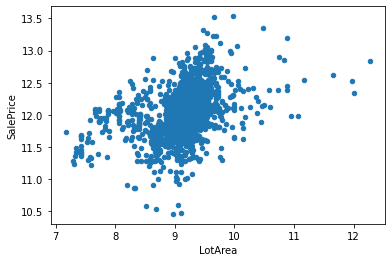

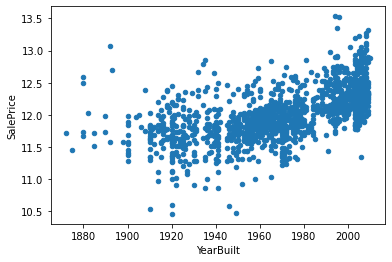

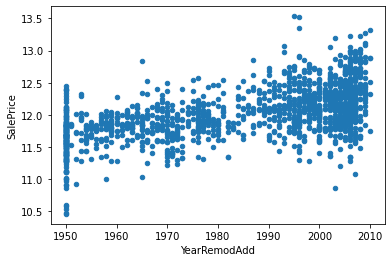

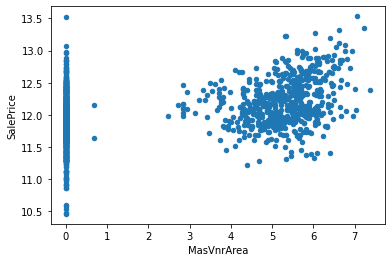

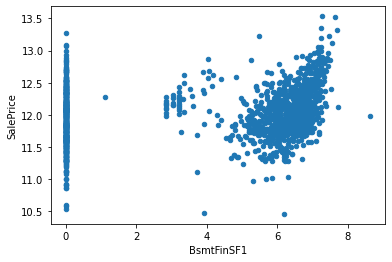

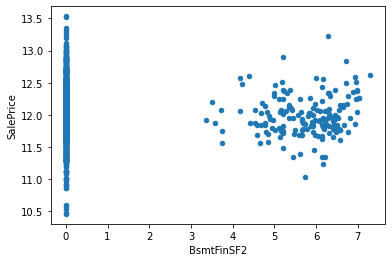

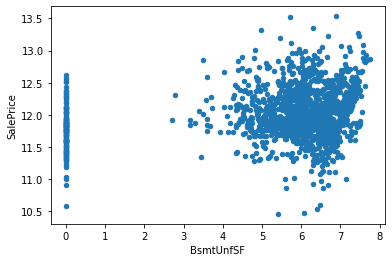

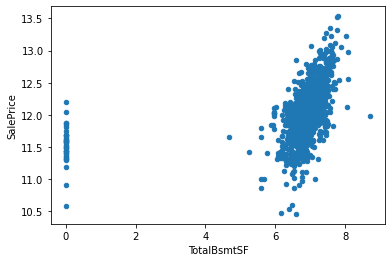

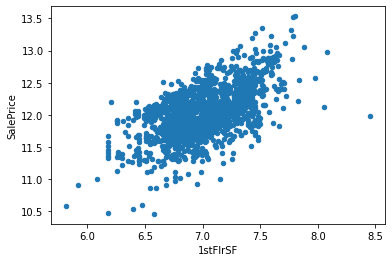

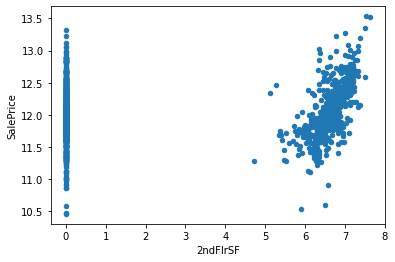

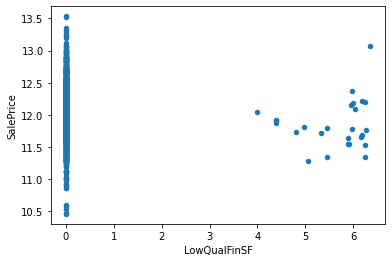

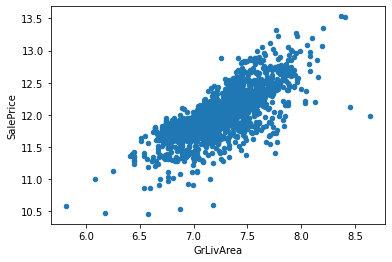

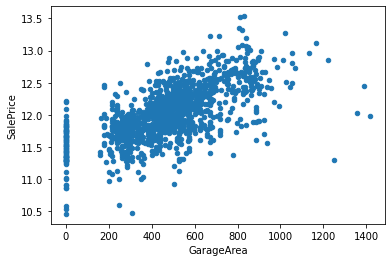

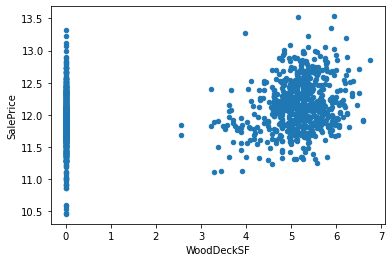

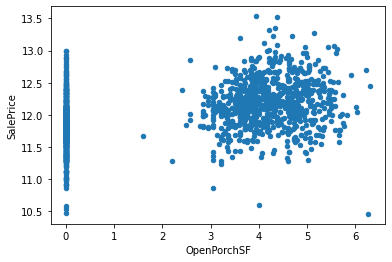

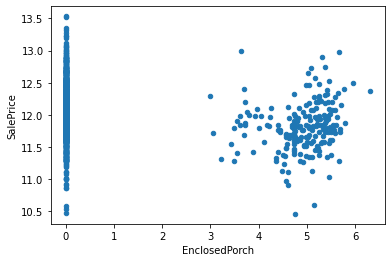

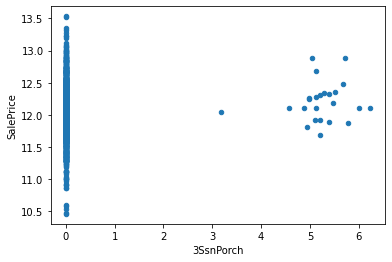

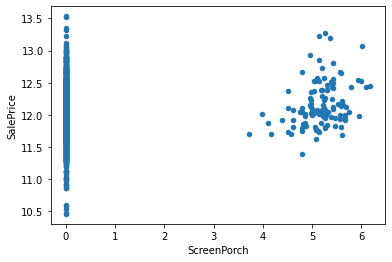

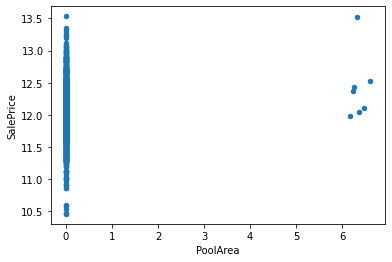

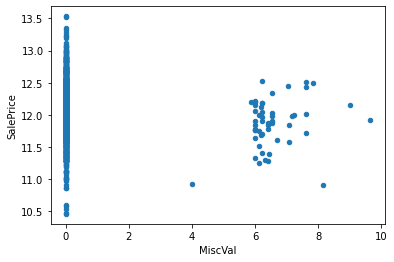

In [56]:
# let's observe the relationship between SalePrice and numerical variables in X (find outliers, correlation, ...)
for var in num_var:
  data = pd.concat([y_final, X_final[var]], axis=1)
  data.plot.scatter(x=var, y='SalePrice');

In [ ]:
data = pd.concat([y_final, X_final], axis=1)

# delete outliers of 'GrLivArea'
to_drop_gla = list(data.index[(data['GrLivArea']>8.3) & (data['SalePrice']<12.25)])
X_final = X_final.drop(labels=to_drop_gla)
y_final = y_final.drop(labels=to_drop_gla)

# delete outliers of 'GarageArea'
to_drop_ga = list(data.index[(data['GarageArea']>1200) & (data['SalePrice']<12.5)])
to_drop_ga = list(set(to_drop_ga) - set(to_drop_gla))
X_final = X_final.drop(labels=to_drop_ga)
y_final = y_final.drop(labels=to_drop_ga)

# delete outliers of '1stFlrSF'
to_drop = list(X_final.index[X_final['1stFlrSF']>8.4])
X_final = X_final.drop(labels=to_drop)
y_final = y_final.drop(labels=to_drop)

# delete outliers of 'TotalBsmtSF'
to_drop = list(X_final.index[X_final['TotalBsmtSF']>8.5])
X_final = X_final.drop(labels=to_drop)
y_final = y_final.drop(labels=to_drop)

# delete outliers of 'BsmtFinSF1'
to_drop = list(X_final.index[X_final['BsmtFinSF1']>8])
X_final = X_final.drop(labels=to_drop)
y_final = y_final.drop(labels=to_drop)

# delete outliers of 'LotArea'
to_drop = list(X_final.index[X_final['LotArea']>11.5])
X_final = X_final.drop(labels=to_drop)
y_final = y_final.drop(labels=to_drop)

In [62]:
X_test = df_test[list(X_final.columns)]

In [63]:
# filling in the missing values of numerical columns
num_X_final = X_final[num_var]
num_X_test = X_test[num_var]

my_imputer = SimpleImputer(strategy='mean')

num_X_final = pd.DataFrame(my_imputer.fit_transform(num_X_final)).reset_index(drop=True)
num_X_test = pd.DataFrame(my_imputer.transform(num_X_test)).reset_index(drop=True)

num_X_final.columns = X_final[num_var].columns
num_X_test.columns = X_test[num_var].columns

In [64]:
# apply one hot encoder for categorical variables
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_final = pd.DataFrame(OH_encoder.fit_transform(X_final[cat_var]))
OH_cols_final.columns = OH_encoder.get_feature_names()
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cat_var]))
OH_cols_test.columns = OH_encoder.get_feature_names()

# One-hot encoding removed index; put it back
OH_cols_final.index = X_final.index
OH_cols_test.index = X_test.index

OH_cols_final.reset_index(drop=True, inplace=True)
OH_cols_test.reset_index(drop=True, inplace=True)

In [68]:
# determine X final and test sets with the transformed columns
X_final = pd.concat([num_X_final, OH_cols_final, X_final[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)
X_test = pd.concat([num_X_final, OH_cols_final, X_final[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)

In [69]:
model = XGBRegressor(n_estimators=250, learning_rate=0.05)
model.fit(X_final, y_final)

# get predictions
predictions = model.predict(X_test)

[10:50:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
print(predictions)

[12.232501 12.030304 12.25289  ... 12.473542 11.829868 11.966397]


In [77]:
data_final = pd.concat([X_test, pd.Series(predictions)], axis=1)
data_final.rename(columns={0: 'SalePricePredicted'}, inplace=True)
data_final

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,x42_Abnorml,x42_AdjLand,x42_Alloca,x42_Family,x42_Normal,x42_Partial,Garage,Bsmt,Pool,SalePricePredicted
0,9.042040,2003.0,2003.0,5.283204,6.561031,0.000000,5.017280,6.753438,6.753438,6.751101,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.232501
1,9.169623,1976.0,1976.0,0.000000,6.886532,0.000000,5.652489,7.141245,7.141245,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.030304
2,9.328212,2001.0,2002.0,5.093750,6.188264,0.000000,6.075346,6.825460,6.825460,6.765039,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.252890
3,9.164401,1915.0,1970.0,0.000000,5.379897,0.000000,6.293419,6.629363,6.869014,6.629363,...,1.0,0.0,0.0,0.0,0.0,0.0,True,True,False,11.905840
4,9.565284,2000.0,2000.0,5.860786,6.486161,0.000000,6.196444,7.044033,7.044033,6.960348,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.548082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,8.976894,1999.0,2000.0,0.000000,0.000000,0.000000,6.860664,6.860664,6.860664,6.543912,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.097375
1447,9.486152,1978.0,1988.0,4.787492,6.673298,5.099866,6.380123,7.341484,7.637234,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.240049
1448,9.109746,1941.0,2006.0,0.000000,5.620401,0.000000,6.777647,7.050123,7.080868,7.050123,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,12.473542
1449,9.181735,1950.0,1996.0,0.000000,3.912023,6.937314,0.000000,6.983790,6.983790,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,True,True,False,11.829868
